In [39]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Data Loader

In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [43]:
bs = 1000
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [44]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([1000, 3, 64, 64])

In [45]:
label2cat = train_set.classes
label2cat

['cat', 'dog', 'wild']

# Arsitektur & Config

In [46]:
from jcopdl.layers import conv_block, linear_block

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conf = nn.Sequential(        
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )           
        
        self.fc = nn.Sequential(        
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 3, activation="lsoftmax")
        )
        
        
    def forward(self, x):
        x = self.conf(x)
        x = self.fc(x)
        return x       

In [49]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation > MCOC

In [50]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [51]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.0833 | Test_cost  = 1.0243 | Train_score = 0.3923 | Test_score = 0.5373 |




Epoch     2
Train_cost  = 0.9453 | Test_cost  = 0.8355 | Train_score = 0.5562 | Test_score = 0.6060 |




Epoch     3
Train_cost  = 0.8003 | Test_cost  = 0.7027 | Train_score = 0.6424 | Test_score = 0.6880 |




Epoch     4
Train_cost  = 0.7030 | Test_cost  = 0.6302 | Train_score = 0.6925 | Test_score = 0.7333 |




Epoch     5
Train_cost  = 0.6256 | Test_cost  = 0.5271 | Train_score = 0.7381 | Test_score = 0.7913 |




Epoch     6
Train_cost  = 0.5655 | Test_cost  = 0.4785 | Train_score = 0.7675 | Test_score = 0.8147 |




Epoch     7
Train_cost  = 0.5154 | Test_cost  = 0.4125 | Train_score = 0.7913 | Test_score = 0.8393 |




Epoch     8
Train_cost  = 0.4534 | Test_cost  = 0.3693 | Train_score = 0.8208 | Test_score = 0.8600 |




Epoch     9
Train_cost  = 0.4445 | Test_cost  = 0.3547 | Train_score = 0.8251 | Test_score = 0.8633 |




Epoch    10
Train_cost  = 0.4008 | Test_cost  = 0.3474 | Train_score = 0.8435 | Test_score = 0.8680 |




Epoch    11
Train_cost  = 0.4013 | Test_cost  = 0.3661 | Train_score = 0.8433 | Test_score = 0.8640 |
==> EarlyStop patience =  1 | Best test_score: 0.8680




Epoch    12
Train_cost  = 0.3915 | Test_cost  = 0.3555 | Train_score = 0.8472 | Test_score = 0.8660 |
==> EarlyStop patience =  2 | Best test_score: 0.8680




Epoch    13
Train_cost  = 0.3648 | Test_cost  = 0.3135 | Train_score = 0.8604 | Test_score = 0.8933 |




Epoch    14
Train_cost  = 0.3381 | Test_cost  = 0.3071 | Train_score = 0.8751 | Test_score = 0.8833 |
==> EarlyStop patience =  1 | Best test_score: 0.8933




Epoch    15
Train_cost  = 0.3328 | Test_cost  = 0.3147 | Train_score = 0.8732 | Test_score = 0.8893 |
==> EarlyStop patience =  2 | Best test_score: 0.8933




Epoch    16
Train_cost  = 0.3260 | Test_cost  = 0.2589 | Train_score = 0.8759 | Test_score = 0.9033 |




Epoch    17
Train_cost  = 0.3077 | Test_cost  = 0.2555 | Train_score = 0.8841 | Test_score = 0.9107 |




Epoch    18
Train_cost  = 0.2886 | Test_cost  = 0.2677 | Train_score = 0.8939 | Test_score = 0.9007 |
==> EarlyStop patience =  1 | Best test_score: 0.9107




Epoch    19
Train_cost  = 0.2816 | Test_cost  = 0.2369 | Train_score = 0.8927 | Test_score = 0.9133 |




Epoch    20
Train_cost  = 0.2763 | Test_cost  = 0.2186 | Train_score = 0.8976 | Test_score = 0.9187 |


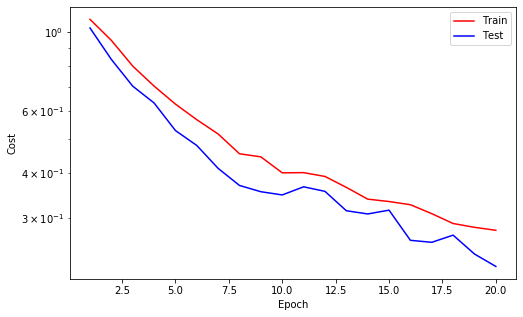

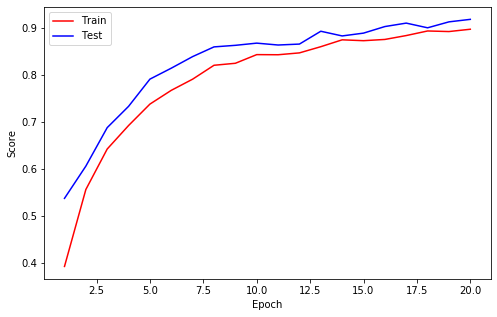



Epoch    21
Train_cost  = 0.2797 | Test_cost  = 0.2119 | Train_score = 0.8962 | Test_score = 0.9220 |




Epoch    22
Train_cost  = 0.2662 | Test_cost  = 0.2079 | Train_score = 0.9011 | Test_score = 0.9260 |




Epoch    23
Train_cost  = 0.2438 | Test_cost  = 0.2068 | Train_score = 0.9083 | Test_score = 0.9260 |
==> EarlyStop patience =  1 | Best test_score: 0.9260




Epoch    24
Train_cost  = 0.2548 | Test_cost  = 0.1995 | Train_score = 0.9040 | Test_score = 0.9273 |




Epoch    25
Train_cost  = 0.2465 | Test_cost  = 0.2018 | Train_score = 0.9085 | Test_score = 0.9247 |
==> EarlyStop patience =  1 | Best test_score: 0.9273




Epoch    26
Train_cost  = 0.2365 | Test_cost  = 0.2132 | Train_score = 0.9124 | Test_score = 0.9213 |
==> EarlyStop patience =  2 | Best test_score: 0.9273




Epoch    27
Train_cost  = 0.2257 | Test_cost  = 0.1800 | Train_score = 0.9150 | Test_score = 0.9347 |




Epoch    28
Train_cost  = 0.2188 | Test_cost  = 0.1902 | Train_score = 0.9200 | Test_score = 0.9313 |
==> EarlyStop patience =  1 | Best test_score: 0.9347




Epoch    29
Train_cost  = 0.2231 | Test_cost  = 0.1728 | Train_score = 0.9163 | Test_score = 0.9373 |




Epoch    30
Train_cost  = 0.2094 | Test_cost  = 0.1729 | Train_score = 0.9241 | Test_score = 0.9347 |
==> EarlyStop patience =  1 | Best test_score: 0.9373




Epoch    31
Train_cost  = 0.2070 | Test_cost  = 0.1656 | Train_score = 0.9246 | Test_score = 0.9380 |




Epoch    32
Train_cost  = 0.2022 | Test_cost  = 0.1687 | Train_score = 0.9252 | Test_score = 0.9360 |
==> EarlyStop patience =  1 | Best test_score: 0.9380




Epoch    33
Train_cost  = 0.1990 | Test_cost  = 0.1719 | Train_score = 0.9258 | Test_score = 0.9380 |
==> EarlyStop patience =  2 | Best test_score: 0.9380




Epoch    34
Train_cost  = 0.1952 | Test_cost  = 0.1635 | Train_score = 0.9282 | Test_score = 0.9373 |
==> EarlyStop patience =  3 | Best test_score: 0.9380


In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [35]:
feature, target = next(iter(trainloader))
feature, target = feature.to(device), target.to(device)

In [36]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1,
        1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0, 0, 2, 1, 2,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 1, 0,
        1, 0, 0, 2, 1, 2, 2, 1, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2,
        1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0,
        1, 2, 2, 2, 0, 1, 1, 2])

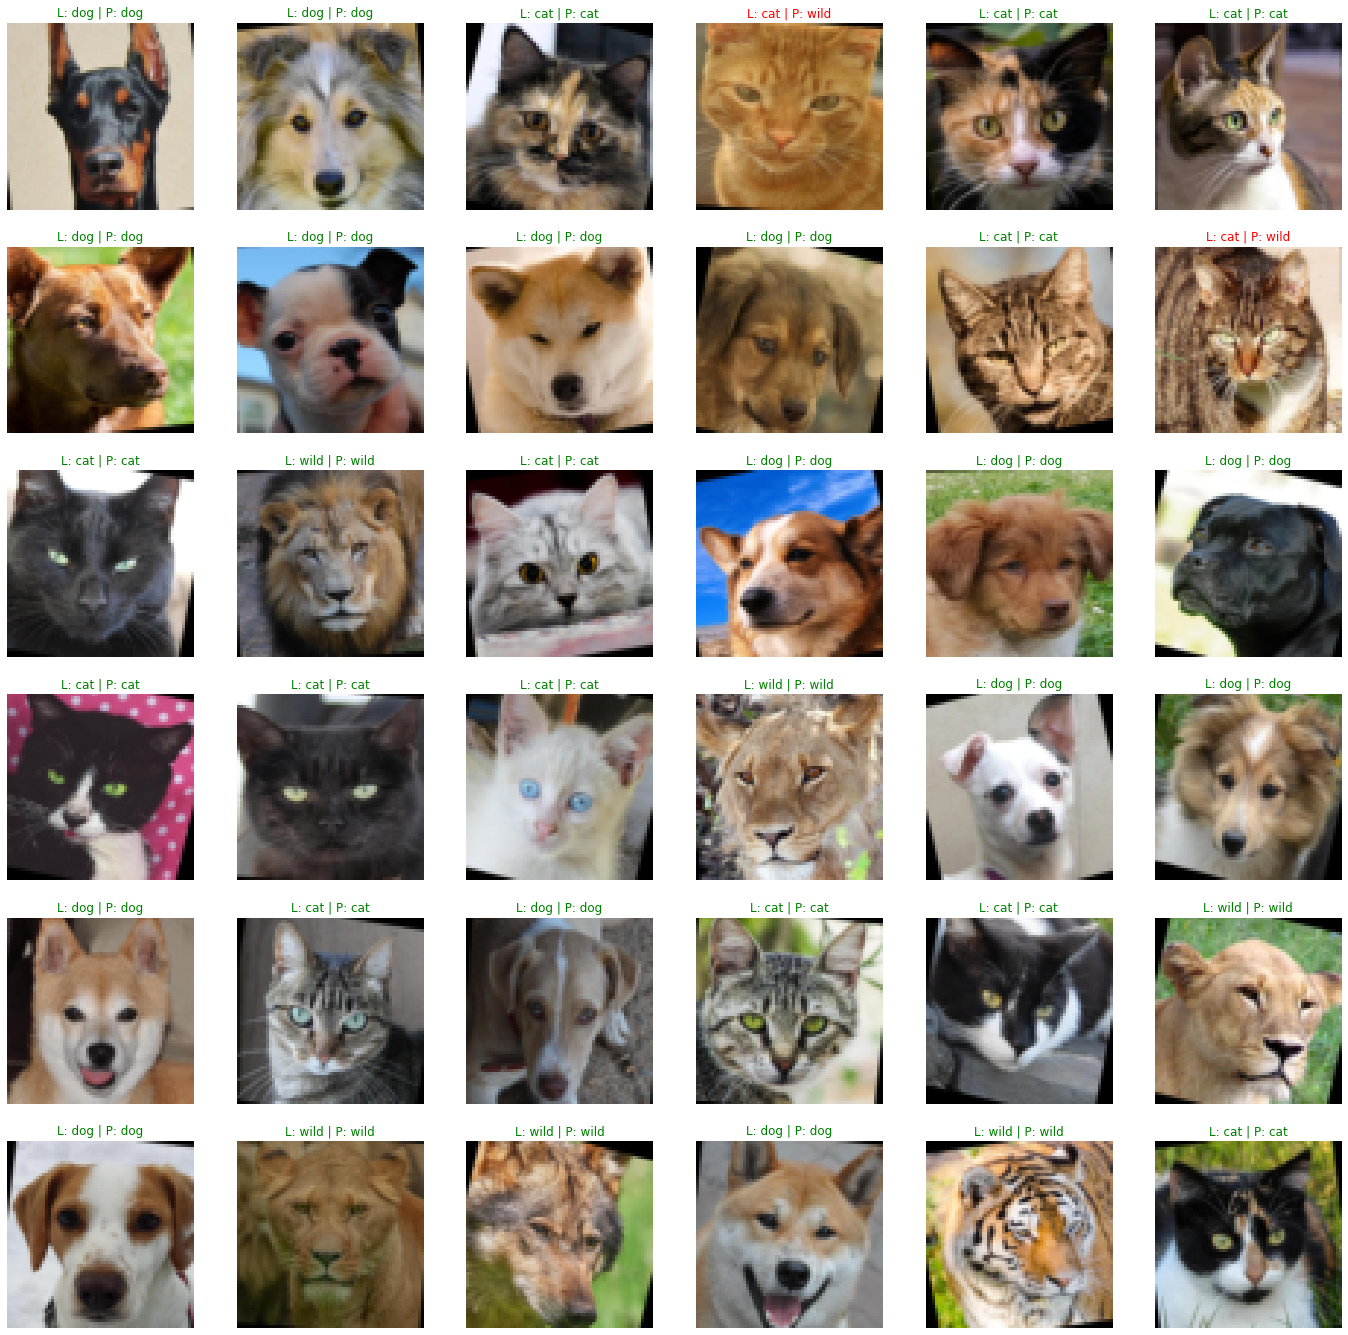

In [38]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');